# Word Level OCR for Persian Language
## Based on Recurrent Neural Networks
Amirabbas Asadi, amir137825@gmail.com

## Requirements
- Pandas, Numpy
- Pytorch
- OpenCV
- imgaug

## Dataset
I created a Synthetic dataset called Shotor containing 120000 images and correspond words.  
[Download The Dataset](https://github.com/amirabbasasadi/Shotor)

## Loading and using images

In [3]:
from imgaug import augmenters as iaa
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('dark')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from random import randint

In [2]:

pip install imgaug

   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ---------------------------------------- 10.2/948.0 kB ? eta -:--:--
   - ------------------------------------- 30.7/948.0 kB 435.7 kB/s eta 0:00:03
   - ------------------------------------- 41.0/948.0 kB 393.8 kB/s eta 0:00:03
   -- ------------------------------------ 61.4/948.0 kB 409.6 kB/s eta 0:00:03
   --- ----------------------------------- 81.9/948.0 kB 459.5 kB/s eta 0:00:02
   --- ----------------------------------- 92.2/948.0 kB 403.5 kB/s eta 0:00:03
   ---- --------------------------------- 122.9/948.0 kB 400.9 kB/s eta 0:00:03
   ----- -------------------------------- 143.4/948.0 kB 405.9 kB/s eta 0:00:02
   ------ ------------------------------- 163.8/948.0 kB 426.7 kB/s eta 0:00:02
   ------ ------------------------------- 174.1/948.0 kB 403.5 kB/s eta 0:00:02
   ------- ------------------------------ 194.6/948.0 kB 406.9 kB/s eta 0:00:02
   -------- ----------------------------- 204.8/948.0 kB 

### Some configurations

In [4]:
# input images width
img_width = 100
# input images height
img_height = 50
# every image will be splited into <img_splits> parts
img_splits = 20
# maximum length of each word
word_max_len = 15
# device for tensors
# current version is sequential and GPU has not a significant effect
# I didn't test the model on GPU 
device = 'cpu' 

### Set dataset path

In [9]:
dataset_path = "C:/Users/RGS/Downloads/Shotor_Images.tar/Shotor_Images"
csv_words_path = 'Shotor_Words.csv'

In [5]:
import os
import tarfile

def extract_tar_file(tar_file_path, extract_to_folder=None):
    if extract_to_folder is None:
        # ساختن نام پوشه بر اساس نام فایل tar
        extract_to_folder = os.path.splitext(tar_file_path)[0]
    
    if not os.path.exists(extract_to_folder):
        os.makedirs(extract_to_folder)
    
    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=extract_to_folder)
        print(f"Extracted all files to {extract_to_folder}")

# مسیر فایل .tar را مشخص کنید
tar_file_path = 'Shotor_Images.tar.gz'

# فراخوانی تابع برای استخراج فایل
extract_tar_file(tar_file_path)

Extracted all files to Shotor_Images.tar


### Creating dataset object
It is easier to define a dataset object for using data for Pytorch models

In [10]:
class PersianOCR(Dataset):
    """Persian Hand-Written dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # read the csv file
        self.csv = pd.read_csv(csv_file)
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        word = self.csv.iloc[idx, 1]
        image = io.imread(img_name)
        
        item = {'image': image, 'word': word}

        if self.transform:
            item = self.transform(item)

        return item

dataset = PersianOCR(csv_words_path, dataset_path)

### Checking the raw dataset
Take a look at some random words from dataset

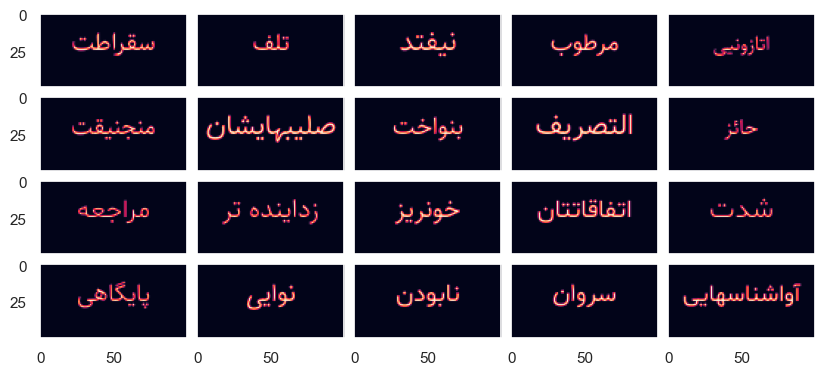

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  images.append(dataset[randint(0, len(dataset)-1)]['image'])

for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

### Converting Words and Images to Pytorch Tensors
We should define all persian alphabets.
Also we define `S` as start token and `E` as end token and `-` as blank character which is used for CTCLoss that we wanna use and is different from space character.

In [12]:
# define all persian alphabets
pchars = "آ ا ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی ئ"
pchars = ['-',' ', 'S', 'E'] + pchars.split(' ')
letter_to_index = {}
for i in range(len(pchars)):
  letter_to_index[pchars[i]] = i
enc_dim = len(pchars)

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        image = image.reshape(-1, img_height, img_width)
        if (len(word) > word_max_len):
          word = word[:word_max_len]
        word = word + 'E'
        original_word = [[letter_to_index[c]] for c in word]
        return {'image': torch.from_numpy(image).double(),
                'word' : torch.LongTensor(original_word)}

### Augmentation Pipeline
using imgaug we can define an Augmentation pipeline. It helps to train a robust model and useable for more realistic data. It randomly applies some of 5 augmentations.

In [14]:
class ImageAug(object):
    """Apply Image Augmentation on style and output"""

    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        aug = iaa.SomeOf((0, 5), [
            iaa.Affine(scale={"x": (0.80, 1.20), "y": (0.80, 1.20)}),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
            iaa.Add((-30, 30)),
            iaa.Multiply((0.80, 1.20)),
            iaa.GaussianBlur(sigma=(0, 0.2))
        ])
        image = aug(images=image)
        return {'image': image,
                'word': word}


### Create Dataset with Transformations

In [15]:
transformed_dataset = PersianOCR(csv_words_path, dataset_path,
                                 transform=transforms.Compose([ImageAug(), ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=True)

### See some samples from transformed dataset

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

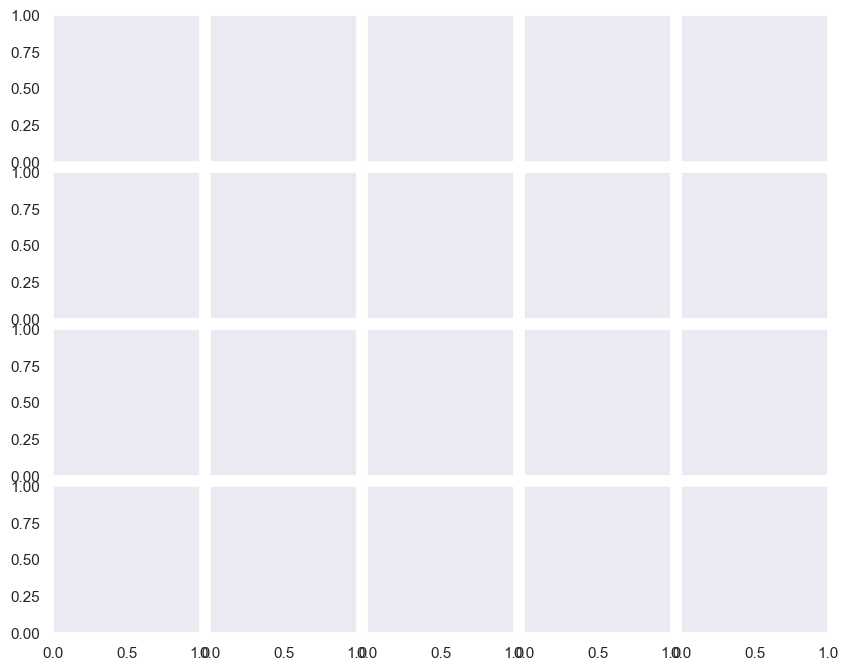

In [16]:
dataiter = iter(dataloader)

fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  batch = dataiter.next()
  images.append(batch['image'][0][0])

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

## Defining a Recurrent Neural Network in Pytorch

In [17]:
import torch.nn as nn

class OCRNet(nn.Module):
    def __init__(self, img_size, hidden_size):
        super(OCRNet, self).__init__()
        self.hidden_size = hidden_size
        self.img_size = img_size
        self.enc_img_size = 200
        self.fc1 = nn.Linear(self.img_size, 450)
        self.fc2 = nn.Linear(450, self.enc_img_size)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.CELU()
        self.i2h = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 80)
        self.h2h = nn.Linear(80, 60)
        self.h2h2 = nn.Linear(60, self.hidden_size)
        self.i2o = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 200)
        self.o2o = nn.Linear(200, enc_dim)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x, input, hidden):
        x = x.reshape((1, -1))
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.drop(x)
        combined = torch.cat((x, input.view((1, -1)), hidden.view((1, -1))), 1)
        hidden = self.act(self.i2h(combined))
        hidden = self.act(self.h2h(hidden))
        hidden = self.h2h2(hidden)
        output = self.act(self.i2o(combined))
        output = self.o2o(output)
        output = self.softmax(output)
        
        return output, hidden


net = OCRNet(int(img_width/img_splits)*img_height, enc_dim).double()
net = net.to(device)
print(net)
print("Number of Parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

OCRNet(
  (fc1): Linear(in_features=250, out_features=450, bias=True)
  (fc2): Linear(in_features=450, out_features=200, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (act): CELU(alpha=1.0)
  (i2h): Linear(in_features=276, out_features=80, bias=True)
  (h2h): Linear(in_features=80, out_features=60, bias=True)
  (h2h2): Linear(in_features=60, out_features=38, bias=True)
  (i2o): Linear(in_features=276, out_features=200, bias=True)
  (o2o): Linear(in_features=200, out_features=38, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Number of Parameters:  295526


## Training The Model

### Generating start token

In [18]:
def get_start_token():
  start_token = torch.zeros((1, enc_dim), dtype=torch.double).to(device)
  start_token[0][letter_to_index['S']] = 1
  return start_token

### Defining Optimizer

In [19]:
import torch.optim as optim

# I suggest to decrease the learning rate after each epoch
# for the first one I used lr = 0.0002 and for the second lr = 0.00005
optim_learning_rate = 0.0002

criterion = nn.CTCLoss() 
optimizer = optim.Adam(net.parameters(), lr=optim_learning_rate, betas=(0.5, 0.999))

epochs = 1
mini_batchs = 100
loss_values = []

### Training
After two epochs I saw an acceptable output. on CPU each epoch might take 1-2 hours.

In [20]:
net.train()
step = int(img_width / img_splits)
input_seq_len = torch.tensor([img_splits], dtype=torch.long)
for epoch in range(epochs):
    loss = 0
    mini_batch_loss = 0
    for i, data in enumerate(dataloader, 0):
        # get the input
        image, word = data['image'], data['word']
        image = image.to(device)
        word = word.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # initialize the RNN hidden state
        hidden = torch.zeros((1, enc_dim)).double().to(device)
        output = get_start_token()
        letters = []
        for j in range(img_splits):
          output, hidden = net(image[:, :, :,
                                     step*(img_splits-j-1):step*(img_splits-j)],
                                     output, hidden)
          letters.append(output)

        # concatinate the outputs
        predicted_word = torch.cat(letters, dim=1).view(img_splits, 1, enc_dim)
        
        target_seq_len = torch.tensor([word.size(1)],
                                      dtype=torch.long)
        
        # compairing the output and word based on CTCLoss
        loss = criterion(predicted_word, word.view((1, -1)),
                          input_seq_len, target_seq_len)
        
        loss.backward()
        
        optimizer.step()
        
        mini_batch_loss += loss.item()
        
        if i % mini_batchs == (mini_batchs-1):
            
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, mini_batch_loss/mini_batchs))
            
            loss_values.append(mini_batch_loss)    
        
            mini_batch_loss = 0

[1,   100] loss: 4.83345
[1,   200] loss: 3.45263
[1,   300] loss: 3.13846
[1,   400] loss: 3.06678
[1,   500] loss: 3.12708
[1,   600] loss: 2.91429
[1,   700] loss: 2.71475
[1,   800] loss: 2.72150
[1,   900] loss: 2.66005
[1,  1000] loss: 2.56593
[1,  1100] loss: 2.59197
[1,  1200] loss: 2.41867
[1,  1300] loss: 2.43153
[1,  1400] loss: 2.44329
[1,  1500] loss: 2.21629
[1,  1600] loss: 2.30483
[1,  1700] loss: 2.15486
[1,  1800] loss: 2.33906
[1,  1900] loss: 2.14928
[1,  2000] loss: 2.13275
[1,  2100] loss: 2.10067
[1,  2200] loss: 2.15100
[1,  2300] loss: 2.09424
[1,  2400] loss: 1.99479
[1,  2500] loss: 1.88583
[1,  2600] loss: 1.78727
[1,  2700] loss: 1.92418
[1,  2800] loss: 1.68597
[1,  2900] loss: 1.80998
[1,  3000] loss: 1.61276
[1,  3100] loss: 1.79078
[1,  3200] loss: 1.81087
[1,  3300] loss: 1.73891
[1,  3400] loss: 1.57146
[1,  3500] loss: 1.67944
[1,  3600] loss: 1.37385
[1,  3700] loss: 1.32057
[1,  3800] loss: 1.71056
[1,  3900] loss: 1.48994
[1,  4000] loss: 1.51849


### Checking The Loss values

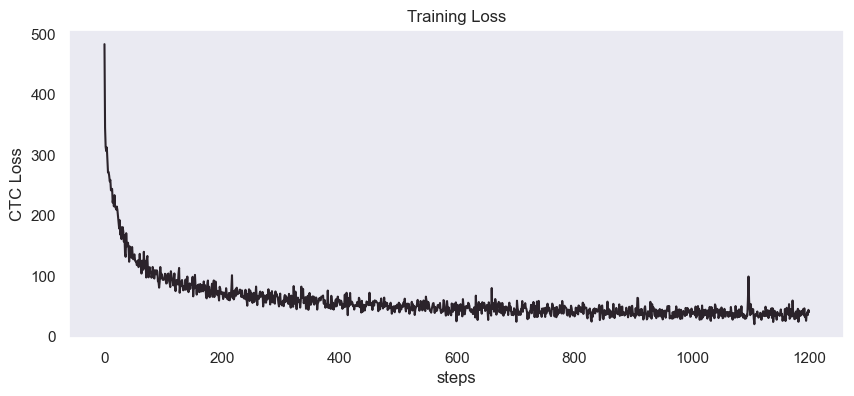

In [21]:
sns.set_palette(sns.dark_palette("purple"))
fig, ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(ax=ax,y=loss_values, x=range(len(loss_values)))
plot.set_title("Training Loss")
plot.set_xlabel("steps")
plot.set_ylabel("CTC Loss")
plt.show()

## Using The Model for converting a page

### Cleaning The Ouput
Due to the CTCLoss we should clear the ouput from repeated characters then `-` (blank) characters. 

In [22]:
import re
def clean_ctc(s):
    # remove repeated
    word = ""
    prev = ""
    for c in s:
      if(c != prev):
        word += c
      prev = c
    word = re.sub('[\-SE]', '', word)
    return word

### Converting Output Tensor To Word

In [23]:
def tensor_to_word(word_tensor):
    word_tensor = word_tensor.max(2)[1].view(-1)
    word = ""
    for i in range(word_tensor.size(0)):
      word += pchars[word_tensor[i]]
    return clean_ctc(word)

### Transforming Numpy Images for evaluation

In [24]:
def transform_numpy_image(img):
    # scale the image
    img = img.reshape(1, 1, 50, 100)
    tensor = torch.from_numpy(img).double().to(device)
    return tensor

### Feeding Image to Model 

In [25]:
def image_to_word(img):
    tensor = transform_numpy_image(img)
    prediction = None
    net.eval()
    with torch.no_grad():
      hidden = torch.zeros((1, enc_dim)).double().to(device)
      output = get_start_token()
      letters = []
      for j in range(img_splits):
        step = int(img_width / img_splits)
        output, hidden = net(tensor[:, :, :, step*(img_splits-j-1):step*(img_splits-j)], output, hidden)
        letters.append(output)
      prediction = torch.cat(letters, dim=0).view(img_splits, 1, enc_dim)
    return tensor_to_word(prediction)

### Reading The Text Image

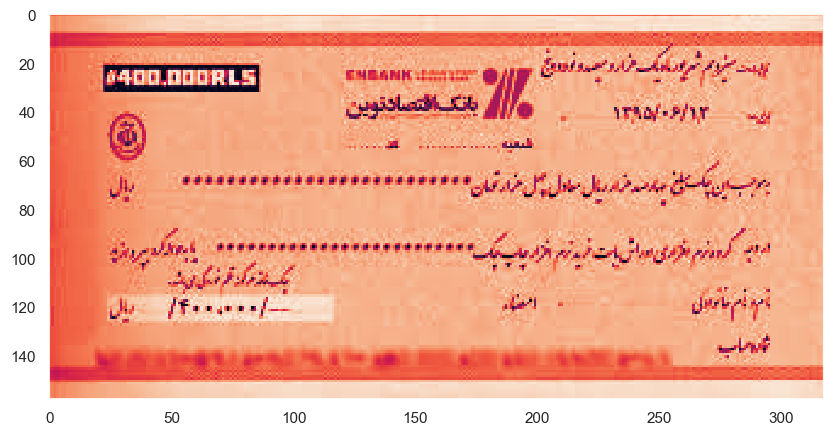

In [139]:
import cv2
%matplotlib inline
image_path = "C:/Users/RGS/Downloads/download (3).jfif"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

### Thresholding The Image

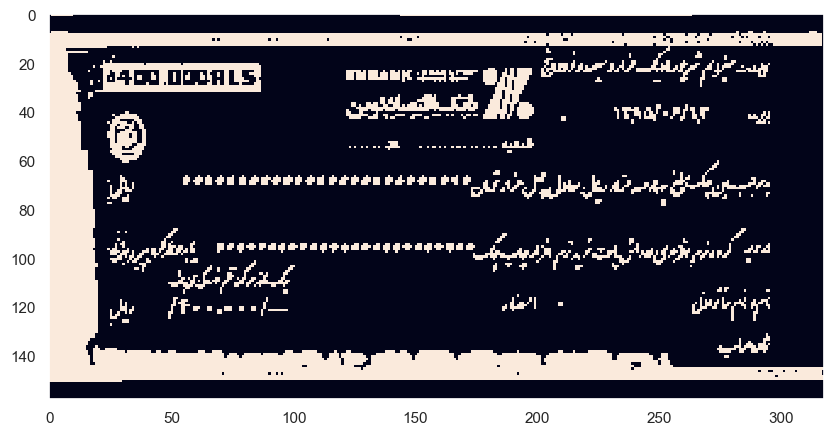

In [140]:
ret,thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(thresh, interpolation='nearest')

### Using dilation to segment the words

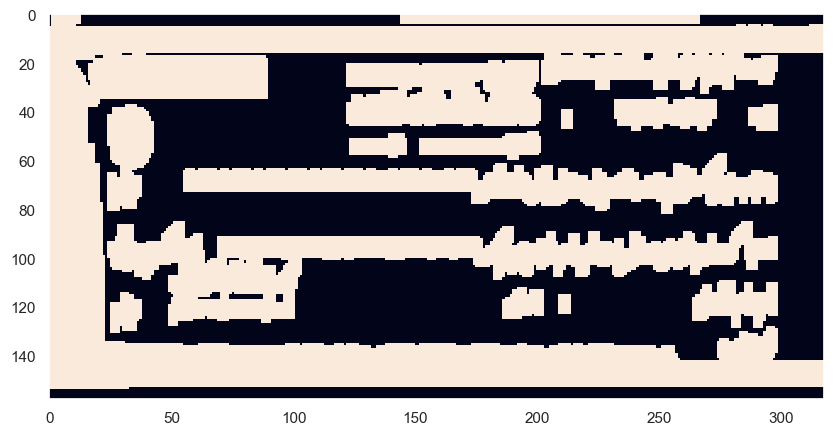

In [141]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 3))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 3)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(dilation, interpolation='nearest')

### Finding The Contours

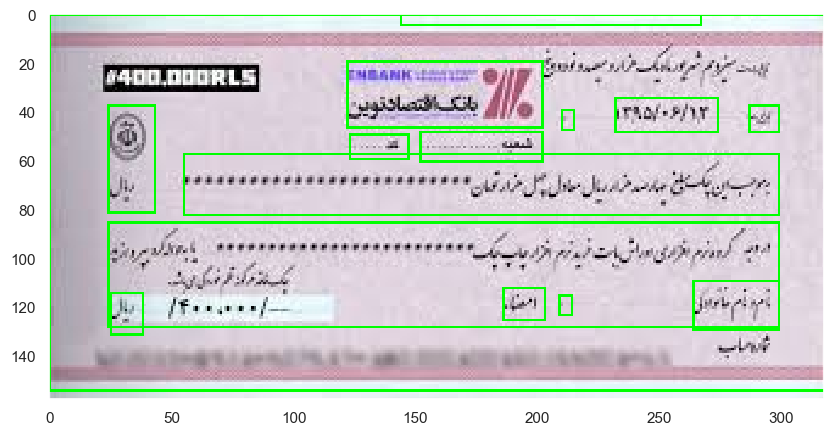

In [142]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
img_contours = img.copy()
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 255, 0), 1)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(img_contours, interpolation='nearest')

### Sorting The Contours

In [143]:
from functools import cmp_to_key

def rectCmp(r1, r2):
  if (abs(r1[1] - r2[1]) < 20):
    return r2[0] - r1[0]
  return r1[1] - r2[1]

bounding_rects = [ cv2.boundingRect(c) for c in contours ]
bounding_rects.sort(key=cmp_to_key(rectCmp))

In [144]:

bounding_rects

[(144, 0, 123, 4),
 (287, 37, 12, 11),
 (232, 34, 42, 14),
 (122, 19, 80, 27),
 (0, 0, 318, 154),
 (210, 39, 5, 8),
 (152, 48, 50, 12),
 (123, 49, 24, 10),
 (24, 37, 19, 44),
 (55, 57, 244, 25),
 (24, 85, 275, 43),
 (264, 109, 35, 20),
 (209, 115, 5, 8),
 (186, 112, 17, 13),
 (25, 114, 13, 17)]

### Extract Images

In [145]:
def extract_images(rects, image):
  images = []
  for r in rects:
    x, y, w, h = r
    H=50
    W=100
    Y = int((H-h)/2) - 5
    X = int((W-w)/2) - 5
    c = np.zeros((H, W))
    c[Y:Y+h, X:X+w] = 1-image[y:y+h, x:x+w]
    c[c < 70] = 0
    c *= 1.8
    c[c > 255] = 255
    c = np.floor(c)
    images.append(c)
  return images
test_images = extract_images(bounding_rects, gray)

ValueError: could not broadcast input array from shape (4,123) into shape (4,16)

In [146]:
import numpy as np

def extract_images(rects, image):
    images = []
    for r in rects:
        x, y, w, h = r
        H = 50
        W = 100
        
        # محاسبه مقادیر X و Y به گونه‌ای که اندیس‌ها معتبر باشند
        Y = max(int((H - h) / 2) - 5, 0)
        X = max(int((W - w) / 2) - 5, 0)
        
        # ایجاد ماتریس c با اندازه H و W
        c = np.zeros((H, W))
        
        # محاسبه محدوده‌های معتبر برای اندیس‌ها
        y1, y2 = max(0, Y), min(Y + h, H)
        x1, x2 = max(0, X), min(X + w, W)
        
        # استخراج ناحیه مورد نظر از تصویر و تخصیص به ماتریس c
        c[y1:y2, x1:x2] = 1 - image[y:y + (y2 - y1), x:x + (x2 - x1)]
        
        # پردازش تصویر
        c[c < 70] = 0
        c *= 1.8
        c[c > 255] = 255
        c = np.floor(c)
        
        images.append(c)
    return images

# فرض کنید bounding_rects و gray قبلاً تعریف شده‌اند
test_images = extract_images(bounding_rects, gray)

In [147]:
' '.join([image_to_word(image) for image in test_images])

'بیبیب م بهه عقجیویم عوتهسس ب سدیبیب هی زقو مسسسس ععتوتکتتاگهمکو وبشع ب بت بم'

## Final Result
After 2 epochs the result should be meangful

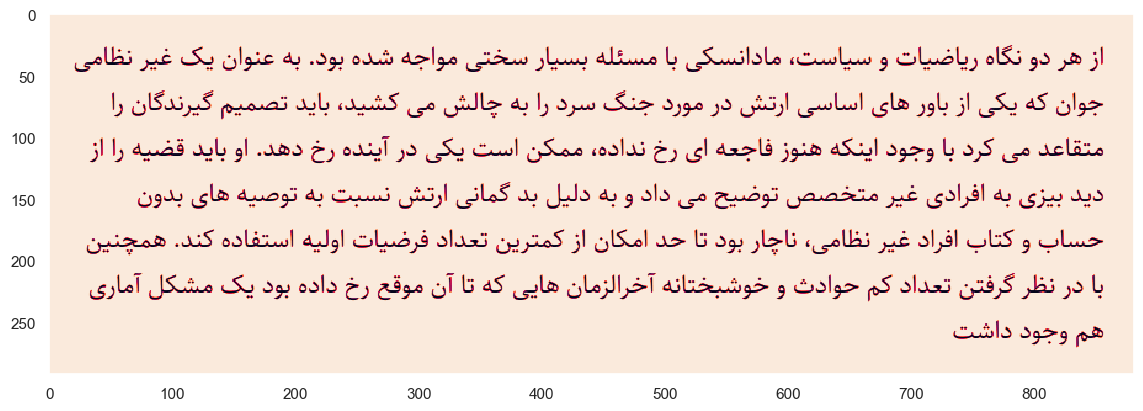

In [55]:
import cv2
%matplotlib inline
image_path = 'test_page.png'

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [41]:
' '.join([image_to_word(image) for image in test_images])

'از هر دو نگاه رباخیات و سباست مادانسکی با مسزلد بسیار سنحنتی مواجه شده بود به عنولان یک غیر نامی جوان کی بکی از باور های اساسب ارتش دن موند جنگ سرد را به الش عمی کشیده باید تصمبیم گیرندگان با منتظاعد عمی کرد با وچود اینکه هنوز فاجعه ای رنش ننادهی ممکن است بکی در آیندمه رش دهد او باید غضیه را از دید بیزگ به افرادی غیر متحعه توضبت می داد و به دلیل بد گمانی ارتش نسبت به توحبه های بدون حساب و کتاب افراد غیر نضلامی ناجار بود تا حد امکان از کمترین تعیداد فرضیات اولیه استاده کندد ههجنبن بار در نر گرفتن تمداد کع حوادت و جوشبجتانه آخرالزمان هرایی کی تا آن موقع رش داده بود یک مشکل آماری هم وچود کداشت'

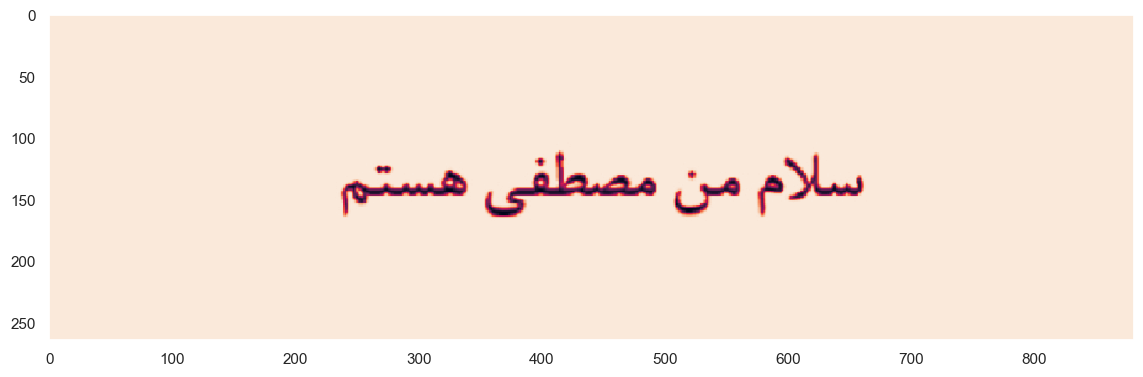

In [91]:
import cv2
%matplotlib inline
image_path = "C:/Users/RGS/Downloads/Screenshot 2024-07-12 172627.jpg"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [92]:
' '.join([image_to_word(image) for image in test_images])

'هرعا هو مه هققوقمس هقیو س هوهو'

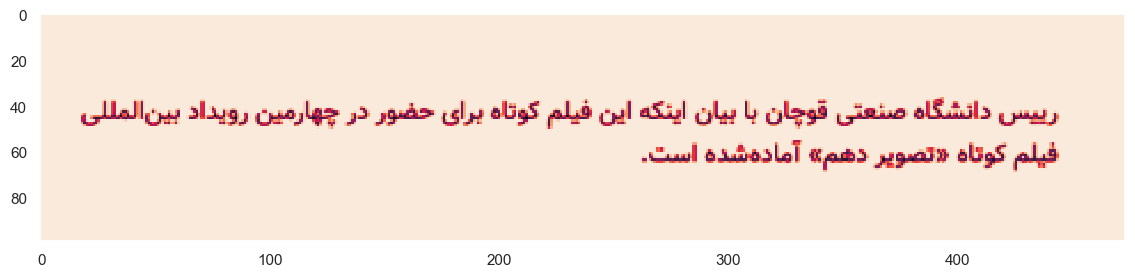

In [103]:
import cv2
%matplotlib inline
image_path = "C:/Users/RGS/Downloads/download.png"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [104]:
' '.join([image_to_word(image) for image in test_images])

'مم س ایغاه کوده ولمهیر منن ن هعهفغماسه سار له ار هنب پواهری مر سم ست روهسنریاه بالم'

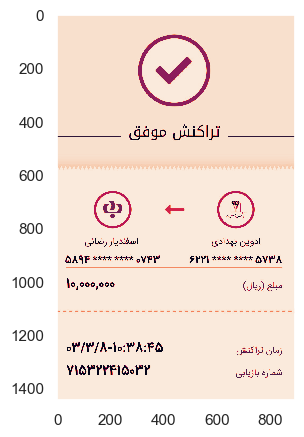

In [115]:
import cv2
%matplotlib inline
image_path = 'C:/Users/RGS/Downloads/Screenshot_58.jpg'

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [116]:
' '.join([image_to_word(image) for image in test_images])

'عهقهقهم لآس ا ط ی م مسسم گرآاقگ العیمبیچم سس سس مهم وویم  مهم قوم قه ا د م تاگتریل لژگذه آ ارعه ل قغکعقلرند ژل ق یر تغا قیکا گ گاه یگ کققو چلگاوجه نق گقوکهوطقورگق قوویو گق قاگقعقایا ص طئسگولطارهو گقگاوطزهق گآا آگق آققهوه کمزلک رزابل نچپ قار گو قع قل یقگ قار ههر ق ق وگع  س سر س س سر س س س سر س سر س س س س س س سر س س س س سر سر سر س س س سر س س سر م س س س س سر س غر عآ را لاا زگیفیلا گهقهرگها عه ه قق قگق  چ قوگ ق ب قگی گق رالقق ت آقآ ه نهعتا غر ض گا لرگتا گواعقا غیقیه آ گقااقلقهالقا آقهوه آ گهق تعح'

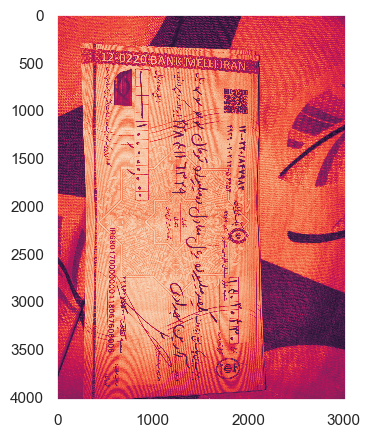

In [126]:
import cv2
%matplotlib inline
image_path = "D:/IMG_1413.jpg"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [127]:
' '.join([image_to_word(image) for image in test_images])

'اق فق و ه و و اق ق ق و ه ه ه قظ و ف و و و ه ف ق و و و و ق و فق ه و ا و ق ه هق ق قظ و ق و و و و ه ه هق ق و و و ق ق ه و س ق ف و و  و ا ق بس بس ق و ق و و هقو و و و ق و و ه و و و و ه و و  و و هو ف قو و و و و و و و و و و و ه ه و و و و قو و و و ف و اق ه و ه و و و و و و و و و غ و ق و ق و و و و و و و و و و و و و و ق  ق و و هظ و و و و و و و ق ه قو و ق و فق و هق و یا و اق و هق و ق ه و و و و ه ه و و و و و و و و و و و هق ق و ق و ق و و و و و ف و و ق و و و هق و و و و و و و و و ه و ه و و و و و و و و و و ق ه و و و ق و و ه ق ق و و و و و ق و و ه و و ه ق ه و و و ف و و و و و و ق قو و قو ه و ق و و و و و و ه ق ق و و و و و و ه و ق و و و و و ه ه و و و و و و و و ع و و ه و و ه هق ه و و ه و ق و و و و قو فق ه و ققو و و ققهقق و ق ف و ا هقهق  و و قو ه و و و ق ق هق و و و و و و و و و و و و و و ه و ق و و  ف و و ق و و و سسب و و فو قظ اق ه و و و و و ق و ا و و و و و و ه و و ق پس ف  ه و و و و و و و ه و ه و و و  و و ف و و و ه قو و و و ه ق و و ه ق قو ه ف ا و و ه و و و و ا و و ه ق ق و و و و و ق و و قو و و و و و ا و ق و ه و 

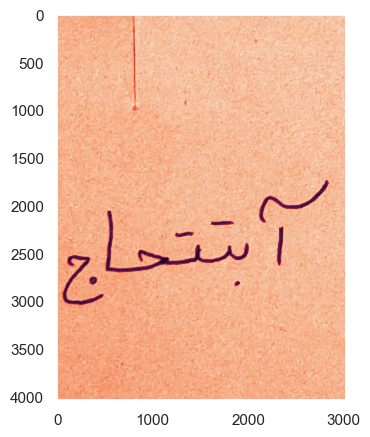

In [137]:
import cv2
%matplotlib inline
image_path = "D:/IMG_1598.jpg"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [138]:
' '.join([image_to_word(image) for image in test_images])

'هق ل ییهم س غیهق آا سسس بس س فیس'

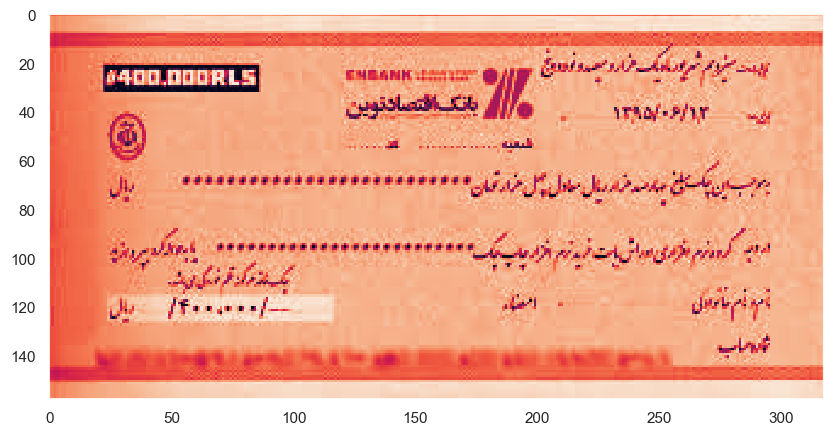

In [148]:
import cv2
%matplotlib inline
image_path = "C:/Users/RGS/Downloads/download (3).jfif"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

In [149]:
' '.join([image_to_word(image) for image in test_images])

'بیبیب م بهه عقجیویم عوتهسس ب سدیبیب هی زقو مسسسس ععتوتکتتاگهمکو وبشع ب بت بم'

## References
This paper helped me a lot, however my architecture is not same
- https://arxiv.org/abs/1805.09441
- [Pytorch Tutorial on RNNs](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)  
For word segmentation using dilation see this:
- https://stackoverflow.com/a/10970473/4334320

The text of the image which I used to show the final result is a translation of this book:
- The Theory That Would Not Die, Sharon McGrayne